In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from os import listdir
from os.path import isfile, join
import re
import datetime
import numpy as np

import importlib
import detect_maneuver # put it in a .py so it can be used by the SOCRATES detection part also
importlib.reload(detect_maneuver);

In [2]:
# def remove_strange_data(input_df):
#     # remove points that randomly spiked
#     df = input_df.reset_index()
#     s_diff_diff = (df.SEMIMAJOR_AXIS.diff()-df.SEMIMAJOR_AXIS.diff(-1)).abs()+1
#     s_diff_sum = (df.SEMIMAJOR_AXIS.diff()+df.SEMIMAJOR_AXIS.diff(-1)).abs()
#     i_diff_diff = (df.INCLINATION.diff()-df.INCLINATION.diff(-1)).abs()+1
#     i_diff_sum = (df.INCLINATION.diff()+df.INCLINATION.diff(-1)).abs()
#     # should return removed rows separately also
#     return (df.loc[~(((s_diff_diff > 0) & (s_diff_sum / s_diff_diff > 1000)) | ((i_diff_diff > 0) & (i_diff_sum / i_diff_diff > 1000)))]).set_index("EPOCH")

# def find_maneuvers(df, maneuver_functions):
#     mdf = df.copy()
#     all_ranges = []
#     for col, name, func, thresholds in maneuver_functions:
#         all_thresholds = []
#         for threshold in thresholds:
#             mdf['maneuvers'] = func(mdf[col])
#             mdf['maneuvered'] = (mdf.maneuvers > threshold) | (mdf.maneuvers < -threshold)
#             mdf['maneuvere_group'] = (mdf.maneuvered != mdf.maneuvered.shift())
#             mdf['maneuvere_group'] = mdf['maneuvere_group'].fillna(False).astype(int).cumsum()
#             grouped = mdf.reset_index().groupby('maneuvere_group')
#             events = pd.DataFrame({'start' : grouped.EPOCH.first(),
#                                    'end' : grouped.EPOCH.last(),
#                                    'v' : grouped.maneuvered.first()}).reset_index(drop=True)
#             events = events[events.v==True][['start','end']]
#             day = pd.offsets.Day()
#             events['start'] = events['start'] - day
#             events['end'] = events['end'] + day
#             events['group'] = (events.start >= events.end.shift()).cumsum()
#             event_ranges = pd.DataFrame({'start' : events.groupby('group').start.first(),
#                                          'end' : events.groupby('group').end.last()}).reset_index(drop=True)
#             all_thresholds.append((threshold, event_ranges))
        
#         all_ranges.append((col, name, mdf[["maneuvers"]], all_thresholds))
#     return all_ranges
    
# def plot_maneuvers(max_x, df, maneuver_results, sat_name):
#     cmap = matplotlib.cm.get_cmap('GnBu')
#     all_axes = []
#     for col, name, maneuvers, thresholds_event_ranges in maneuver_results:
#         fig, axes = plt.subplots(2, 1,figsize=(15,5))
#         all_axes.append(axes)
#         thresholds, event_ranges = zip(*thresholds_event_ranges)
#         fig.suptitle(f'{sat_name}"{col} {name}" function w/ threshold: {thresholds}', fontsize=10)
#         axes[0].set_title(col, fontsize=8)
#         axes[1].set_title(f'"{col} {name}" w/ threshold {thresholds}', fontsize=8)

#         axes[0].set_xlim(df.index[0], max_x)
#         axes[1].set_xlim(df.index[0], max_x)
#         axes[1].set_ylim(-1.5*max(thresholds), 1.5*max(thresholds))
#         axes[0].get_xaxis().set_visible(False)
        
#         df[col].plot(ax=axes[0], label="_", color="chocolate")
#         maneuvers.dropna().plot(ax=axes[1], color="chocolate", legend=False)
#         xmin, xmax = axes[1].get_xlim()
#         for i, threshold in enumerate(thresholds):
#             axes[1].hlines([threshold, -threshold], xmin, xmax, color=cmap((i+1)/(len(thresholds)+2)), linewidth=1)
        
#         for ax in axes:
#             for i, event_range in enumerate(event_ranges):
#                 for _,er in event_range.iterrows():
#                     ax.axvspan(er.start, er.end, alpha=1, color=cmap((i+1)/(len(thresholds)+2)), label="_")
#     return all_axes


In [3]:
satcat = pd.read_csv(f'../satcat_all.csv')

Let's identify the incident from SOCRATES first

In [4]:
path = '../../data/socrates/'
files = [ (match[0],match[1]) for f in listdir(path) if isfile(join(path, f))  if (match:=re.search('^socrates_([0-9]{14})\.csv(\.gz)?$', f))]
files

# Build single dataset
odf = pd.DataFrame()
for file,date in files:
    tmp_df = pd.read_csv(path + file)
    odf = pd.concat([odf,tmp_df])

In [5]:
socrates = odf.copy()
socrates = socrates.sort_values(by="tca_time", ascending=False)
socrates = socrates[socrates.max_prob != 1]
socrates = socrates[socrates.rel_velo_kms > 0.2]
socrates['tca_time'] = socrates['tca_time'].astype('datetime64[ns]')
socrates['extract_date'] = socrates['extract_date'].astype('datetime64[ns]')

# `tca_rounded` is to allow grouping of the same event with slightly different `tca_time`
socrates['tca_rounded'] = socrates['tca_time'].dt.round('30min')

# socrates

In [6]:
path = f'../../../siads591 data/filtered_raw/payload.pkl.gz' # path to the data file
df = pd.read_pickle(path, compression="gzip")

unique_active_satellites = df[df.index > "2020-11-01"].NORAD_CAT_ID.unique()

In [7]:
unique_active_satellites

array([46818, 40053, 43518, ..., 47302, 43728, 47346], dtype=uint16)

Filtering for active satellies in LEO only resulted in the removal of only 1.35% of Socrates entries! That means most of the Socrates entries are related to active LEO satellites. (232204 -> 229079)

In [8]:
active_socrates = socrates.copy()

# each group represents a conjunction event
active_socrates = active_socrates.groupby(by=["sat1_norad","sat2_norad","tca_rounded"]).agg({'max_prob':'max', 'tca_time':'max', 'extract_date':['min','nunique']})
active_socrates.columns = active_socrates.columns.to_flat_index()
active_socrates = active_socrates.reset_index()
active_socrates.columns = ['sat1','sat2','tca_r','max_prob','tca','extract_date','nunique']

# we are evaluating individual satellite maneuvers, so we break up each pair into separate entries
active_socrates = active_socrates.melt(id_vars=['tca_r', 'max_prob', 'tca', 'extract_date', 'nunique'], value_vars=["sat1","sat2"])
active_socrates = active_socrates.drop(columns=['variable'])
active_socrates = active_socrates.rename(columns={'value':'norad_id'})

# filter only for satellites that could potentially move
active_socrates = active_socrates[(active_socrates.norad_id.isin(unique_active_satellites))]
active_socrates = active_socrates.sort_values(by="max_prob", ascending=False)
# active_socrates

In [70]:
# active_socrates contain all the interesting things that we want to look at
# each row represents an active satellite in an event, sorted by max max_prob
it = active_socrates.iterrows()

In [71]:
combined_maneuver_functions = {
    'INCLINATION': [
        ("rolling_10_neightor_diff", lambda x:x.rolling(10, min_periods=1).mean().shift(-9) - x.rolling(10, min_periods=1).mean(), [0.008]),
    ],
    'SEMIMAJOR_AXIS': [
        ("rolling_3_neightor_diff", lambda x:x.rolling(3, min_periods=1).mean().shift(-2) - x.rolling(3, min_periods=1).mean(), [0.025]),
    ],
}

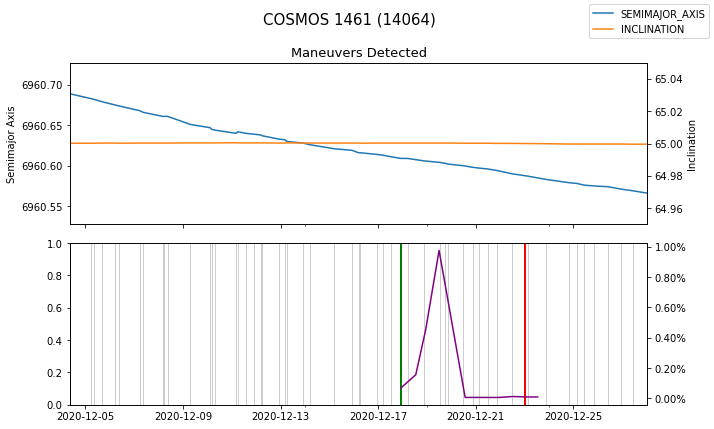

In [134]:
# loop them 1 by 1 manually
while True:
    row = next(it)[1]
    if row["max_prob"] < 0.005:
        break
    norad_id = row['norad_id']
    tca_r = row['tca_r']

    soc_data = socrates[((socrates.sat1_norad == norad_id) | (socrates.sat2_norad == norad_id)) & (socrates.tca_rounded == tca_r)].drop_duplicates(subset=["extract_date"]).sort_values(by="extract_date").copy()
    if len(soc_data) <= 1:
        continue
    # display(soc_data)

    sat = df[df.NORAD_CAT_ID == norad_id].reset_index().copy()
    sat = sat.drop_duplicates(subset=["EPOCH"])
    sat = sat.set_index("EPOCH")[['SEMIMAJOR_AXIS_x1000','INCLINATION_x10000']]
    sat = sat.loc[(sat.index > (soc_data.extract_date.min() - pd.Timedelta("14 days"))) & (sat.index < (soc_data.tca_time.mean() + pd.Timedelta("5 days")))]

    sat['INCLINATION'] = sat['INCLINATION_x10000'].astype(np.float64) / 10000
    sat['SEMIMAJOR_AXIS'] = sat['SEMIMAJOR_AXIS_x1000'].astype(np.float64) / 1000
    sat = sat[['INCLINATION','SEMIMAJOR_AXIS']]
    
    import importlib
    import detect_maneuver # put it in a .py so it can be used by the SOCRATES detection part also
    importlib.reload(detect_maneuver);
    
#     display(sat)
    probs = soc_data[['max_prob','extract_date']].set_index("extract_date")
#     display(probs)
    
    fixed = detect_maneuver.remove_strange_data(sat)
    maneuver_results, combined_results = detect_maneuver.find_maneuvers(fixed, combined_maneuver_functions)
    
    stuff = (fixed, combined_results, f'{satcat.loc[(satcat.NORAD_CAT_ID == norad_id),"SATNAME"].values[0]} ({norad_id}) ')
    fig, ax = plt.subplots(2,1, squeeze=True, figsize=(10,7), sharex=True)
    detect_maneuver.plot_combined_maneuvers(fig, ax[0], *stuff)
    fig.tight_layout(pad=1.5)
    fig.set_facecolor("white")
    fig.legend()
    detect_maneuver.plot_extra_lines(ax[1],sat,probs,soc_data)
    
    break # turn on break to display them 1 by 1 in the notebook
    fig.savefig(f'png output/{f}.png', facecolor='white', transparent=False)
    plt.close()
